# 机器学习报告五:层次聚类
- 姓名：李欣
- 学号：2011165
- 专业：计算机科学与技术

### 基本要求
1. 实现single-linkage层次聚类算法； 
2. 实现complete-linkage层次聚类算法；

### 中级要求
1. 实现average-linkage层次聚类算法； 
2. 将上述三种算法的性能进行简要对比；

### 高级要求
1. 通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析；

### 数据集：数据自行生成
注：数据包含2000个样例，每个样例的前3列表示特征，第4列表示标签。

#### ▲ 需要的包
这里需要注意原本给的是sklearn.datasets.samples_generator，需要修改为sklearn.datasets.`_`samples_generator

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets._samples_generator import make_blobs
from sklearn import metrics

## 0、生成数据集与绘制聚类簇

数据包含2000个样例，每个样例的前3列表示特征，第4列表示标签。

我们将创建数据和绘制数据封装为两个函数，便于调用。

#### 生成数据

In [2]:
# 生成数据
def create_data(centers,num=100,std=0.7):
    '''
    生成用于聚类的数据集
    :param centers: 聚类的中心点组成的数组。如果中心点是二维的，则产生的每个样本都是二维的。
    :param num: 样本数
    :param std: 每个簇中样本的标准差
    :return: 用于聚类的数据集。是一个元组，第一个元素为样本集，第二个元素为样本集的真实簇分类标记
    '''
    X, labels_true = make_blobs(n_samples=num, centers=centers, cluster_std=std)
    return  X,labels_true

In [3]:
centers=[[1,1,1],[1,3,3],[3,6,5],[2,6,8]]# 用于产生聚类的中心点, 聚类中心的维度代表产生样本的维度
X,labels_true= create_data(centers,2000,0.5) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
np.savetxt('data.dat',X)
np.savetxt('label.dat',labels_true)
print("generate data finish!")

generate data finish!


#### 绘制聚类簇

In [4]:
# 绘制聚类簇
def plot_data(*data):
    '''
    绘制用于聚类的数据集
    :param data: 可变参数。它是一个元组。元组元素依次为：第一个元素为样本集，第二个元素为样本集的真实簇分类标记，第三个元素为预测分类标记
    :return: None
    '''
    X,labels_true,labels_predict,cnt = data
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    colors='crgmbykbmyk' # 每个簇的样本标记不同的颜色，不好看，换个颜色
    markers='o^sP*DX'
    for i in range(len(labels_true)):
        predict=labels_predict[i]
        ax.scatter(X[i,0],X[i,1],label="cluster %d"%labels_true[i],
        color=colors[predict%len(colors)],marker=markers[labels_true[i]%len(markers)],alpha=0.5)

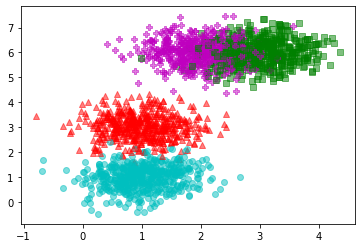

In [5]:
plot_data(X,labels_true,labels_true,0)

## 1、 基本要求
1. 实现single-linkage层次聚类算法； 
2. 实现complete-linkage层次聚类算法；

make_blobs函数

data, label = make_blobs(n_features=2, n_samples=100, centers=3, random_state=3, cluster_std=[0.8, 2, 5])

- n_features 表示每一个样本有多少特征值
- n_samples  表示样本的个数
- centers    聚类中心点的个数，可以理解为label的种类数
- random_state 随机种子，可以固定生成的数据
- cluster_std  设置每个类别的方差

In [6]:
# 1000
MAX_NUM = 1e3

class AgglomerativeClustering:
    def __init__(self):
        # 对每次的合并进行记录
        self.steps=[]

    def fit(self,datas,method):
        # 数据个数
        self.dataCnt = datas.shape[0] # 2000
        
        # 预处理各点之间的距离
        allDist = np.zeros((self.dataCnt,self.dataCnt))
        for i in range(self.dataCnt):
            for j in range(i):
                allDist[i][j] = allDist[j][i] = np.sum((datas[i]-datas[j])**2)
        setList, clusterCount = [[i] for i in range(self.dataCnt)], self.dataCnt
        # print("setlist",setList)
        print("calculate distance finish!")

        # 聚类间距离矩阵
        clusterDist = np.zeros((self.dataCnt,self.dataCnt))+MAX_NUM # 不是很懂，为什么要 + MAX_NUM
        # print("clusterDist ",clusterDist)
        
        # 最开始时，类间距离就是点间距离
        for i in range(clusterCount):
            for j in range(i+1,clusterCount):
                clusterDist[i][j] = clusterDist[j][i] = allDist[i][j]
        print("calculate cluster distance finish!")

        while clusterCount != 1:
            # 最相似的两个聚类
            res = np.argmin(clusterDist)
            # print("res",res)
            dest,src = int(res/clusterCount),res%clusterCount
            # steps进行一次记录
            self.steps.append((setList[dest][0],setList[src][0]))
            # 聚类间距离矩阵更新
            modify = method(clusterDist[[dest,src]],len(setList[dest]),len(setList[src]))
            clusterDist[dest] = modify
            clusterDist[:,dest] = modify
            clusterDist = np.delete(clusterDist,src,axis=0)
            clusterDist = np.delete(clusterDist,src,axis=1)
            clusterDist[dest][dest] = MAX_NUM
            # 聚类更新
            setList[dest] = setList[dest] + setList[src]
            del setList[src]
            clusterCount -= 1
            if (self.dataCnt - clusterCount) % (self.dataCnt / 20) == 0:
                print(clusterCount, " clusters left.")

        print("cluster finish !")

    def label(self,k):
        root = list(range(self.dataCnt))
        def find_root(n):
            if root[root[n]] == root[n]:
                return root[n]
            root[n]=find_root(root[n])
            return root[n]
        for i in range(self.dataCnt-k): # 根据steps记录产生非连通图
            src,dest = self.steps[i]
            root[find_root(dest)] = find_root(src)
        cluster, clusterNum = [0 for i in range(self.dataCnt)], 0
        for i in range(self.dataCnt): # 将根节点标注为新的cluster
            if i == root[i]: # i是根
                clusterNum += 1
                cluster[i] = clusterNum
        for i in range(self.dataCnt): # 将非根节点标注为根节点的cluster
            if i != root[i]: # i不是根
                cluster[i] = cluster[find_root(i)]
        return cluster

#### single-linkage层次聚类

SingleLinkage：又叫做 nearest-neighbor ，就是取两个类中距离最近的两个样本的距离作为这两个集合的距离，也就是说，最近两个样本之间的距离越小，这两个类之间的相似度就越大。容易造成一种叫做 Chaining 的效果，两个 cluster 明明从“大局”上离得比较远，但是由于其中个别的点距离比较近就被合并了，并且这样合并之后 Chaining 效应会进一步扩大，最后会得到比较松散的 cluster 。

In [7]:
def singleLinkage(X,m,n):
    # your code
    dist = np.min(X,axis=0)
    return dist

#### complete-linkage层次聚类

CompleteLinkage：这个则完全是 Single Linkage 的反面极端，取两个集合中距离最远的两个点的距离作为两个集合的距离。其效果也是刚好相反的，限制非常大，两个 cluster 即使已经很接近了，但是只要有不配合的点存在，就顽固到底，老死不相合并，也是不太好的办法。这两种相似度的定义方法的共同问题就是指考虑了某个有特点的数据，而没有考虑类内数据的整体特点。

In [8]:
def completeLinkage(X,m,n):
    # your code
    dist = np.max(X,axis=0)
    return dist

## 2、中级要求
1. 实现average-linkage层次聚类算法； 
2. 将上述三种算法的性能进行简要对比；

#### average-linkage层次聚类

Average-linkage：这种方法就是把两个集合中的点两两的距离全部放在一起求一个平均值，相对也能得到合适一点的结果。average-linkage的一个变种就是取两两距离的中值，与取均值相比更加能够解除个别偏离样本对结果的干扰。在今后的实验中可能会尝试。

对于三种算法的学习理解，参考了[聚类（Clustering）hierarchical clustering层次聚类](https://blog.csdn.net/qq_45802081/article/details/109599760)

In [9]:
def averageLinkage(X,m,n):
    # your code
    dist=[]
    # print(len(X[0]))
    for i in range(len(X[0])):
        dist.append((X[0][i]*m+X[1][i]*n)/(m+n))
    return dist

#### 三种算法

##### 结果可视化

calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
-------Segmentation-------
calculat

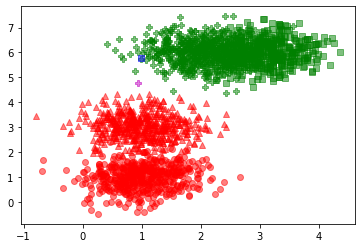

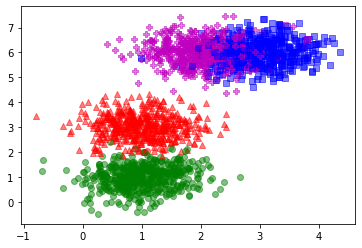

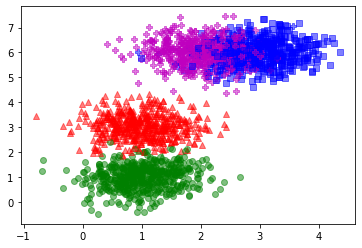

In [10]:
METHOD_APPLY = [singleLinkage,completeLinkage,averageLinkage]
cnt=0
Predict_label=[[],[],[]]
for method in METHOD_APPLY:
    model = AgglomerativeClustering()
    model.fit(X,method)
    k=4
    plot_data(X,labels_true,model.label(k),cnt)
    Predict_label[cnt]=model.label(k)
    # print(model.label(k))
    cnt+=1
    print("-------Segmentation-------")

##### 计算预测与真实两个聚类之间的相似性

In [11]:
METHOD_str = ["single_linkage","complete_linkage","average_linkage"]
ARI = [0,0,0]
for i in range(len(Predict_label)):
    ARI[i] = metrics.adjusted_rand_score(Predict_label[i], labels_true) # 输入 真实标签&预测标签，位置可以交换
    print("method:{}, ari:{:3f}".format(METHOD_str[i],ARI[i]))

method:single_linkage, ari:0.499124
method:complete_linkage, ari:0.989363
method:average_linkage, ari:0.985399


[随机兰德调整指数](https://scikit-learn.org.cn/view/528.html)，兰德指数通过考虑所有样本对并计算在预测的聚类和真实的聚类中分配在相同或不同聚类中的对来计算两个聚类之间的相似性度量。

当聚类簇数量为4，样本个数为2000，每个簇方差均为0.5，簇的中心点分别为[1,1,1],[1,3,3],[3,6,5],[2,6,8]时。

根据图示与ari的计算结果可以看到，使用single_linkage的效果较差，ari为0.499124，使用complete_linkage的效果比较好,ari为0.989363;使用average_linkage的效果也比较好，ari为0.985399;

## 高级要求
1. 通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析；

数据包含2000个样例，每个样例的前3列表示特征，第4列表示标签。

分别测试3、5个聚类 其中，聚类个数为3时方差较小，聚类个数为5时方差较大

#### 聚类簇为3时

原始数据集

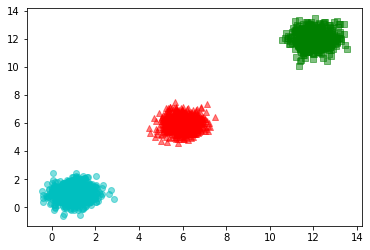

In [12]:
centers_3 = [[1,1],[6,6],[12,12]] # 用于产生聚类的中心点, 聚类中心的维度代表产生样本的维度
X_3,labels_true_3 = create_data(centers_3,2000,0.5) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
plot_data(X_3,labels_true_3,labels_true_3,0)

三种方法分类后可视化

calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
-------Segmentation-------
calculat

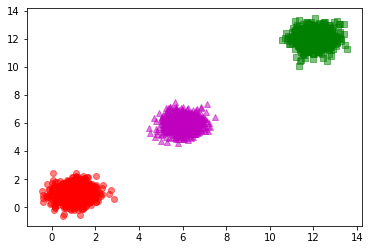

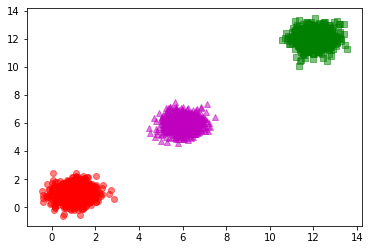

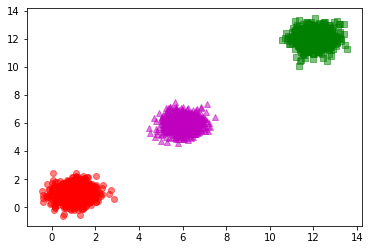

In [13]:
cnt_3 = 0
Predict_label_3=[[],[],[]]
for method in METHOD_APPLY:
    model1 = AgglomerativeClustering()
    model1.fit(X_3,method)
    k=3
    plot_data(X_3,labels_true_3,model1.label(k),cnt_3)
    Predict_label_3[cnt_3]=model1.label(k)
    # print(model.label(k))
    cnt_3+=1
    print("-------Segmentation-------")

In [14]:
ARI_3 = [0,0,0]
for i in range(len(Predict_label_3)):
    ARI_3[i] = metrics.adjusted_rand_score(Predict_label_3[i], labels_true_3) # 输入 真实标签&预测标签，位置可以交换
    print("method:{}, ari:{}".format(METHOD_str[i],ARI_3[i]))

method:single_linkage, ari:1.0
method:complete_linkage, ari:1.0
method:average_linkage, ari:1.0


当簇的个数较少，方差较小，即类内距离较小，类与类之间距离较大时，三种算法的分类效果都很好。

#### 聚类簇为5时

原始数据集

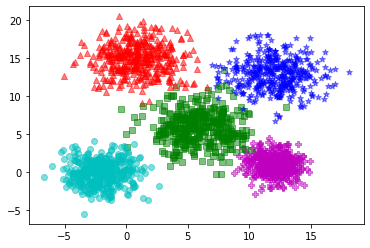

In [15]:
centers_5 = [[-2,0],[1,15],[6,6],[12,1],[12,13]] # 用于产生聚类的中心点, 聚类中心的维度代表产生样本的维度
X_5,labels_true_5 = create_data(centers_5,2000,[1.5,2.0,2.0,1.2,2.0]) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
plot_data(X_5,labels_true_5,labels_true_5,0)

三种方法分类后可视化

calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
-------Segmentation-------
calculat

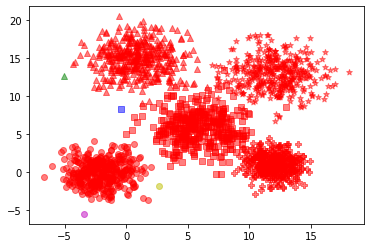

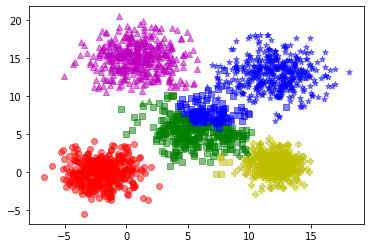

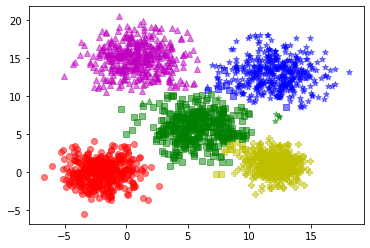

In [16]:
cnt_5 = 0
Predict_label_5=[[],[],[]]
for method in METHOD_APPLY:
    model1 = AgglomerativeClustering()
    model1.fit(X_5,method)
    k=5
    plot_data(X_5,labels_true_5,model1.label(k),cnt_5)
    Predict_label_5[cnt_5]=model1.label(k)
    # print(model.label(k))
    cnt_5+=1
    print("-------Segmentation-------")

In [17]:
ARI_5 = [0,0,0]
for i in range(len(Predict_label_5)):
    ARI_5[i] = metrics.adjusted_rand_score(Predict_label_5[i], labels_true_5) # 输入 真实标签&预测标签，位置可以交换
    print("method:{}, ari:{}".format(METHOD_str[i],ARI_5[i]))

method:single_linkage, ari:-2.4774178579887074e-07
method:complete_linkage, ari:0.85229914629165
method:average_linkage, ari:0.9597579652641809


总结：

1. single_linkage容易造成一种叫做 Chaining 的效果，两个 cluster 明明从“大局”上离得比较远，但是由于其中个别的点距离比较近就被合并了，并且这样合并之后 Chaining 效应会进一步扩大，最后会得到比较松散的 cluster ,这也就导致了在聚类簇较多，且各类的方差较大时，很多本该相异的簇都合并了。

2. complete_linkage则完全是single_linkage 的反面极端，取两个集合中距离最远的两个点的距离作为两个集合的距离。其效果也是刚好相反的，限制非常大，两个 cluster 即使已经很接近了，但是只要有不配合的点存在，就永远都不会合并，也是不太好的办法。这两种相似度的定义方法的共同问题就是指考虑了某个有特点的数据，而没有考虑类内数据的整体特点。这也就导致了聚类簇5且方差较大的情况下，即使点点之间非常接近，也不能够合并为一个簇，分类效果并不是很好。

3. 把两个集合中的点两两的距离全部放在一起求一个平均值，相对能得到更普适的结果，在本实验中分类结果也更好一些。